
# Taks 1: Web scraping

**XJTLU**<br>
**Name:** Jing Yin <br>
**ID:** 2034355<br>

In [14]:
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import csv
import requests
import time
import threading
import urllib.parse
import random

base_url = "http://quotes.toscrape.com"
page_url = base_url + "/page/{}/"
author_url = base_url + "/author/{}/"
search_url_template = "https://www.goodreads.com/quotes/search?utf8=✓&q={}&commit=Search"

# More user-agents are used for random selection to avoid being blocked
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:91.0) Gecko/20100101 Firefox/91.0"
]

# Headers with randomly selected User-Agent for our requests.
def get_random_headers():
    headers = {
        "User-Agent": random.choice(USER_AGENTS),
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
    }
    return headers

# Function to pause the scraper for a random duration to mimic human behavior.
def random_sleep(min_time=1, max_time=3):
    sleep_time = random.uniform(min_time, max_time)
    time.sleep(sleep_time)

# Utility function to clean up and format extracted text.
def clean_text(text):
    cleaned_text = ' '.join(text.split())
    cleaned_text = cleaned_text.strip()
    return cleaned_text

# Global cache for author details to reduce redundant requests
author_cache = {}

# A set to keep track of seen quotes to avoid duplicates
seen_quotes = set()

# Fetches and returns details of an author from a given author URL.
def get_author_details(author_url):
    if author_url in author_cache:
        return author_cache[author_url]

    random_sleep()
    try:
        response = session.get(author_url, headers=get_random_headers())
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        birthday = clean_text(soup.find('span', class_='author-born-date').text)
        country = clean_text(soup.find('span', class_='author-born-location').text.replace('in ', ''))
        description = clean_text(soup.find('div', class_='author-description').text)
        
        author_cache[author_url] = (birthday, country, description)
        return birthday, country, description
    except requests.RequestException as e:
        print(f"Error fetching author details from {author_url}: {e}")
        return ("Unknown", "Unknown", "Unknown")

# Scrapes a single page from quotes.toscrape.com for quotes and author details.
def scrape_page(page_num):
    headers = get_random_headers()
    random_sleep()
    try:
        response = requests.get(page_url.format(page_num), headers=headers, timeout=30)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error making request for page {page_num}: {e}")
        return

    soup = BeautifulSoup(response.text, 'html.parser')
    print(f"Fetched 10 quotes from page {page_num}")

    with threading.Lock():
        for quote in soup.find_all('div', class_='quote'):
            quote_text = clean_text(quote.find('span', class_='text').get_text())

            # Check if we've seen this quote before
            if quote_text in seen_quotes:
                continue

            seen_quotes.add(quote_text)
            author = clean_text(quote.find('small', class_='author').get_text())
            tags = [clean_text(tag.get_text()) for tag in quote.find_all('a', class_='tag')]
            author_link = base_url + quote.find('a')['href']
            birthday, country, description = get_author_details(author_link)
            likes = get_likes_from_goodreads(quote_text)
            
            with open("JingYin2034355.csv", "a", newline='', encoding='utf-8') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([quote_text, author, ', '.join(tags), birthday, country, description, likes])

        print(f"Number of items scraped: {page_num * 10}")


# Bonus:Fetches and returns the number of likes for a quote from Goodreads. 
def get_likes_from_goodreads(quote_text):
    encoded_quote = urllib.parse.quote_plus(quote_text)
    search_url = search_url_template.format(encoded_quote)

    random_sleep()
    try:
        response = requests.get(search_url, headers=get_random_headers())
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        quote_div = soup.find('div', class_='quote')
        if not quote_div:
#     If there is no matching quote found on Goodreads for: {quote_text}, return 0
            return 0

        likes_link = quote_div.find('a', title="View this quote")
        if likes_link:
            return int(likes_link.text.split()[0].replace(',', ''))
        else:
            return 0
    except requests.RequestException as e:
        print(f"Error making request to Goodreads for quote: {e}")
        return 0

if __name__ == "__main__":
    # Use the Session of requests to improve performance
    session = requests.Session()
    
    # Set up the CSV file for saving scraped data.
    # Load already scraped quotes if any
    try:
        with open("JingYin203435.csv", "r", newline='', encoding='utf-8') as csv_file:
            reader = csv.reader(csv_file)
            next(reader)  # skip the header
            seen_quotes.update(row[0] for row in reader)
    except FileNotFoundError:
        pass
    
     # Add header row to the CSV file
    header = ["Quote", "Author", "Tags", "Birthday of Author", "Country of Author", "Description of Author", "Likes"]
    with open("JingYin2034355.csv", "a", newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        
    # Use ThreadPoolExecutor to concurrently execute the scrape_page function, scraping from pages 1 to 10
    max_threads = 5
    with ThreadPoolExecutor(max_threads) as executor:
        for page_num in range(1, 11):
            executor.submit(scrape_page, page_num)

    print("Scraping completed!")

Fetched 10 quotes from page 5
Fetched 10 quotes from page 3
Fetched 10 quotes from page 4
Fetched 10 quotes from page 1
Fetched 10 quotes from page 2
Number of items scraped: 50
Number of items scraped: 30
Fetched 10 quotes from page 6
Fetched 10 quotes from page 7
Error making request to Goodreads for quote: HTTPSConnectionPool(host='www.goodreads.com', port=443): Max retries exceeded with url: /quotes/search?utf8=%E2%9C%93&q=%E2%80%9CThere+is+nothing+I+would+not+do+for+those+who+are+really+my+friends.+I+have+no+notion+of+loving+people+by+halves%2C+it+is+not+my+nature.%E2%80%9D&commit=Search (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
Number of items scraped: 20
Fetched 10 quotes from page 8
Number of items scraped: 10
Number of items scraped: 40
Fetched 10 quotes from page 9Fetched 10 quotes from page 10

Error making request to Goodreads for quote: HTTPSConnectionPool(host='www.goodreads.com', port=4

# Task 2 Data analysis

Here, I will use two methods that data visulization and machine learning to find whether there is some correlation between the identity of the author and the popularity of the quotes. 

## Method 1 : Data Visualization

###  1.1 Box Plots

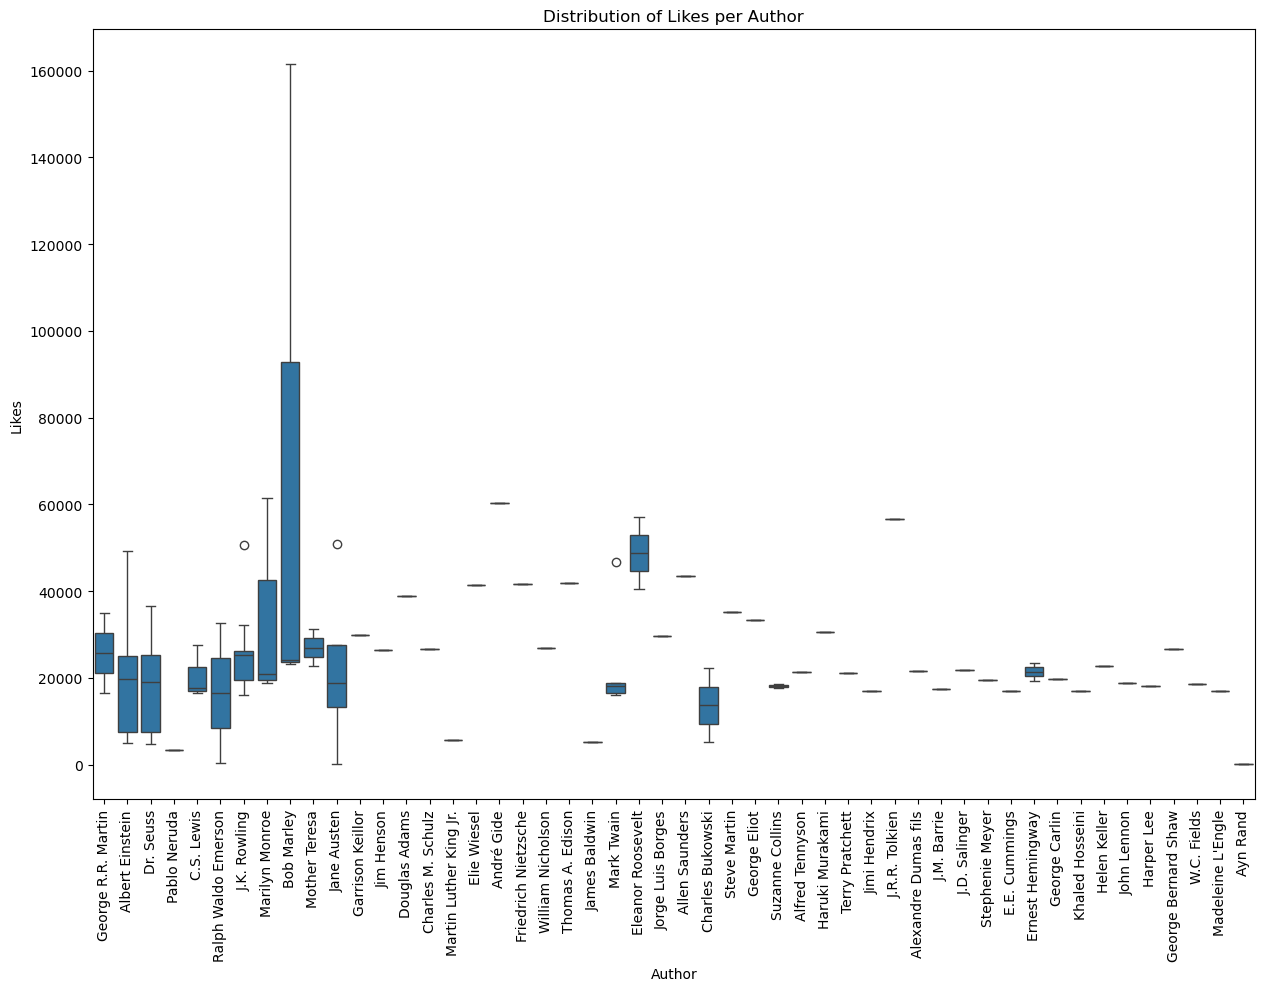

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv("JingYin2034355.csv")

# Remove rows where 'Likes' is 0
data = data[data['Likes'] != 0]
# Leave the last one in the repeating row
data = data.drop_duplicates(subset=['Quote'], keep='last')

# Delete duplicate citations according to the Quote column
data = data.drop_duplicates(subset=['Quote'], keep='last')

# Visualize the distribution of "likes" for each author using a box-whisker diagram
plt.figure(figsize=(15,10))
sns.boxplot(x="Author", y="Likes", data=data)
plt.xticks(rotation=90)  # Turn the X-axis label to fit the graphic
plt.title("Distribution of Likes per Author")
plt.show()

**Analysis**：

1. **Range of Likes**: The number of likes varies greatly across authors, with some authors receiving very few likes (close to 0) and others receiving up to 160,000 likes for some of their quotes.

2. **Outliers**: Several authors have outliers, which are data points that fall far from the other data points. These are represented by the small black dots outside the "whiskers" of the boxplots. For example, authors such as Friedrich Nietzsche and George R. R. Martin have quotes that are exceptionally popular compared to their other quotes.

3. **Highly Liked Authors**: 
   - One author, which appears around the middle of the x-axis, has a quote that has received around 160,000 likes, making it the most liked quote among all the displayed authors.
   - George R. R. Martin seems to have a wider distribution of likes with a median that's higher compared to many other authors. This indicates that many of his quotes are generally well-received.

4. **Least Liked Authors**: 
   - Authors on the extreme left, such as Charles M. Schulz and Douglas Adams, have medians close to the lower end, suggesting that their quotes generally receive fewer likes compared to others.

5. **Variability**: Some authors have a very tight distribution of likes (e.g., J.K. Rowling, J.R.R. Tolkien), suggesting consistency in the popularity of their quotes. In contrast, others like George R. R. Martin and Friedrich Nietzsche have a wider distribution, indicating a greater variability in the likes their quotes receive.

6. **Median Likes**: The horizontal line inside each box represents the median number of likes for each author. Some authors have a high median, indicating that at least 50% of their quotes have a relatively high number of likes.

In summary, this boxplot provides insights into the variability and distribution of likes that different authors receive for their quotes. Some authors have consistently popular quotes, while others have a mix of highly liked and less popular quotes.

###  1.2 Violin Plots

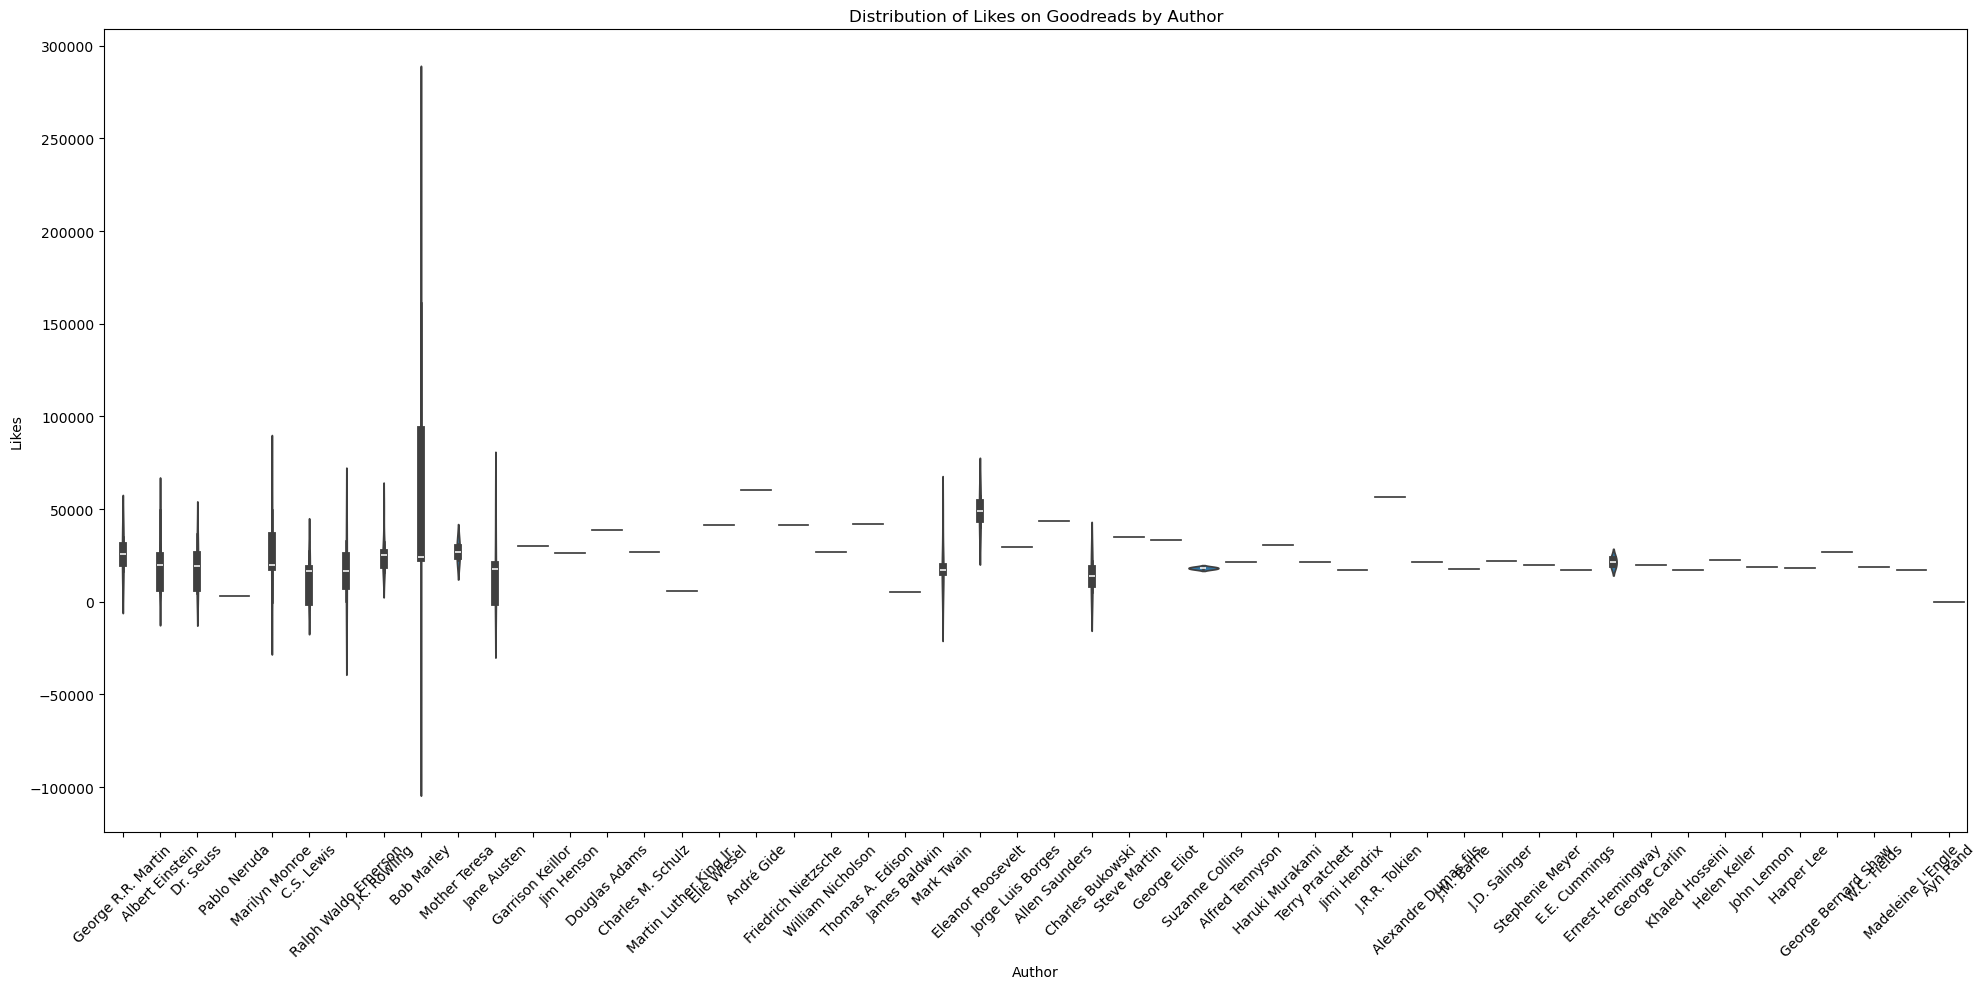

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("JingYin2034355.csv")

# Remove rows where 'Likes' is 0
data = data[data['Likes'] != 0]
# Leave the last one in the repeating row
data = data.drop_duplicates(subset=['Quote'], keep='last')

# Plot the violin with the author on the X-axis and the number of "likes" on Goodreads on the Y-axis
plt.figure(figsize=(20, 10))
sns.violinplot(x="Author", y="Likes", data=df)
plt.xticks(rotation=45)  # The X-axis label is rotated 45 degrees to make it easier to read
plt.title("Distribution of Likes on Goodreads by Author")
plt.tight_layout()
plt.show()


**Analysis**:

1. **Variation in Popularity**: Authors with wider violins have quotes that received a diverse range of likes. This might suggest that some authors' likes are widely distributed, while others are relatively stable.

2. **Outliers**: The violin plot's thin extensions indicate quotes with notably high or low likes compared to others.  These outliers suggest that while the overall popularity might correlate with an author's identity, individual quotes can significantly deviate from the trend, underscoring the importance of content alongside authorship.

3. **Distribution**: The width of the violin plot reflects the data density at that point. A wider section means that there are more quotes from that author at that level of popularity.

4. **Median Popularity**: The white dots in each violin plot represent the median number of "likes" for that author's quote, giving us a central value to measure its popularity.

5. **Negative Values**: There appear to be negative values for "Likes" for some authors. This could be a data error or an artifact of the visualization.

6. **Skewness**:  An upward skew indicates that most of the author's quotes are towards the higher end of the popularity scale, while a downward skew suggests the opposite. Hence, the tilt of the violin chart shows the tendency of most quotes to be popular, and the upward or downward skew indicates that most quotes are relatively high or low in popularity.

## Method 2 : Machine Learning

### 2.1 RandomForestRegressor

Mean Squared Error: 427564728.2486905
                           Author  Importance
4               Author_Bob Marley    0.410917
2               Author_André Gide    0.089789
10       Author_Eleanor Roosevelt    0.086479
25          Author_J.R.R. Tolkien    0.070474
33          Author_Marilyn Monroe    0.046450
11             Author_Elie Wiesel    0.029217
13     Author_Friedrich Nietzsche    0.027428
3                 Author_Ayn Rand    0.027236
27             Author_Jane Austen    0.020277
23            Author_J.K. Rowling    0.019590
26           Author_James Baldwin    0.019346
37            Author_Pablo Neruda    0.018084
38     Author_Ralph Waldo Emerson    0.017701
35  Author_Martin Luther King Jr.    0.016543
39            Author_Steve Martin    0.013786
34              Author_Mark Twain    0.013022
0          Author_Albert Einstein    0.009857
17            Author_George Eliot    0.009809
6         Author_Charles Bukowski    0.009346
8                Author_Dr. Seuss    0.008

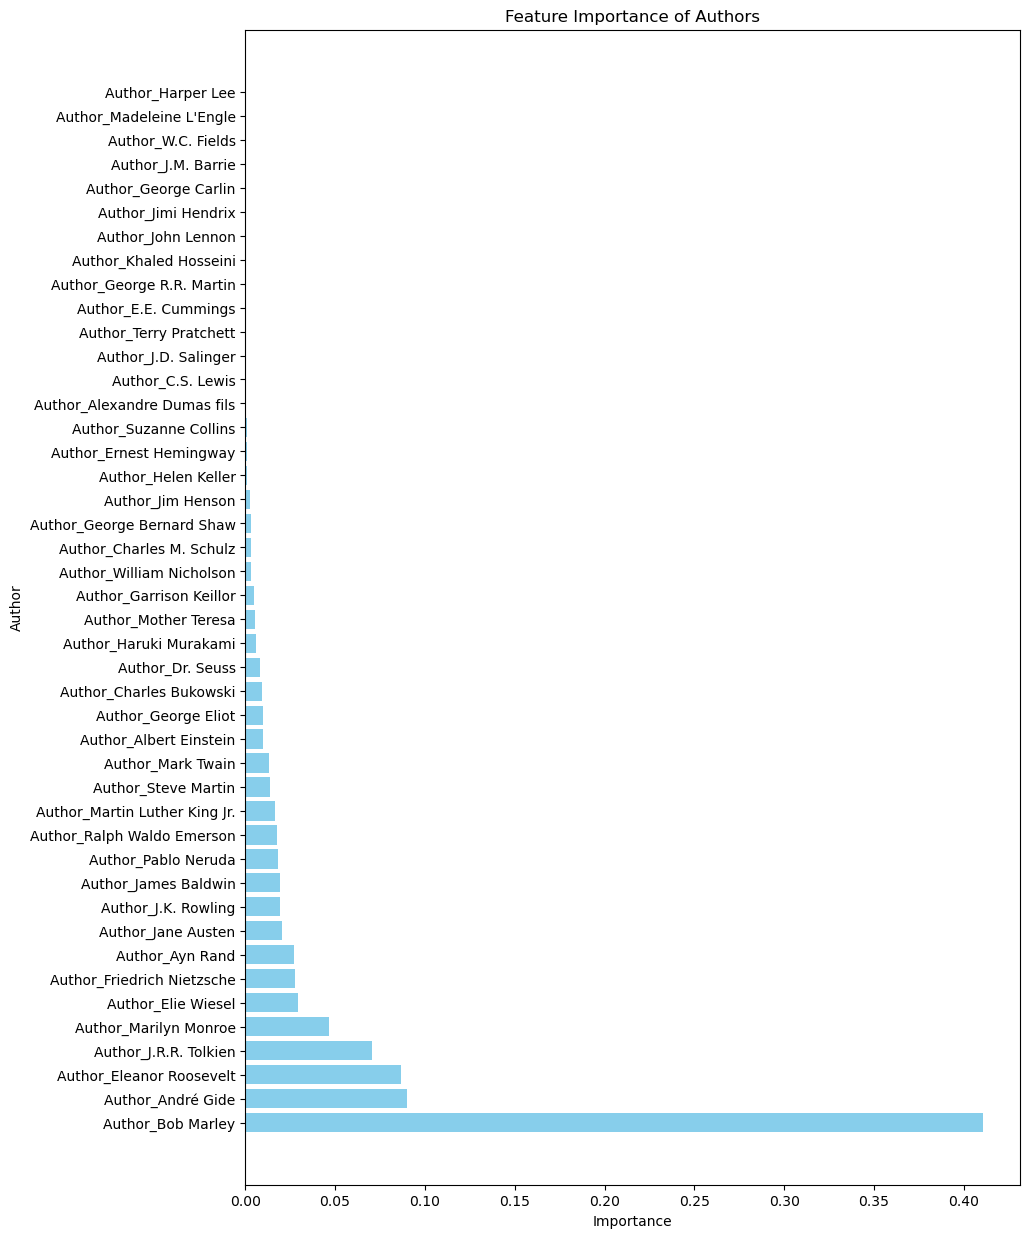

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

# Remove rows where 'Likes' is 0
data = data[data['Likes'] != 0]
# Leave the last one in the repeating row
data = data.drop_duplicates(subset=['Quote'], keep='last')

if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame(data)
    
X = data[["Author"]]
y = data["Likes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Author data is processed using One-Hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Get feature importances
feature_importances = model.feature_importances_
authors = encoder.get_feature_names_out(X.columns)
importance_df = pd.DataFrame({'Author': authors, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10,15))
plt.barh(importance_df['Author'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Author')
plt.title('Feature Importance of Authors')
plt.show()


### 2.2 DecisionTreeRegressor

Mean Squared Error: 501102242.1744093
                          Feature    Importance
4               Author_Bob Marley  5.282476e-01
10       Author_Eleanor Roosevelt  7.718844e-02
2               Author_André Gide  7.701887e-02
25          Author_J.R.R. Tolkien  6.720739e-02
33          Author_Marilyn Monroe  4.320683e-02
3                 Author_Ayn Rand  2.553280e-02
11             Author_Elie Wiesel  2.379514e-02
13     Author_Friedrich Nietzsche  2.350355e-02
37            Author_Pablo Neruda  1.765053e-02
23            Author_J.K. Rowling  1.569995e-02
26           Author_James Baldwin  1.293872e-02
35  Author_Martin Luther King Jr.  1.293115e-02
27             Author_Jane Austen  1.230221e-02
39            Author_Steve Martin  1.111619e-02
17            Author_George Eliot  8.785453e-03
6         Author_Charles Bukowski  5.953603e-03
34              Author_Mark Twain  5.217933e-03
20         Author_Haruki Murakami  5.132941e-03
14        Author_Garrison Keillor  4.793315e-03
36

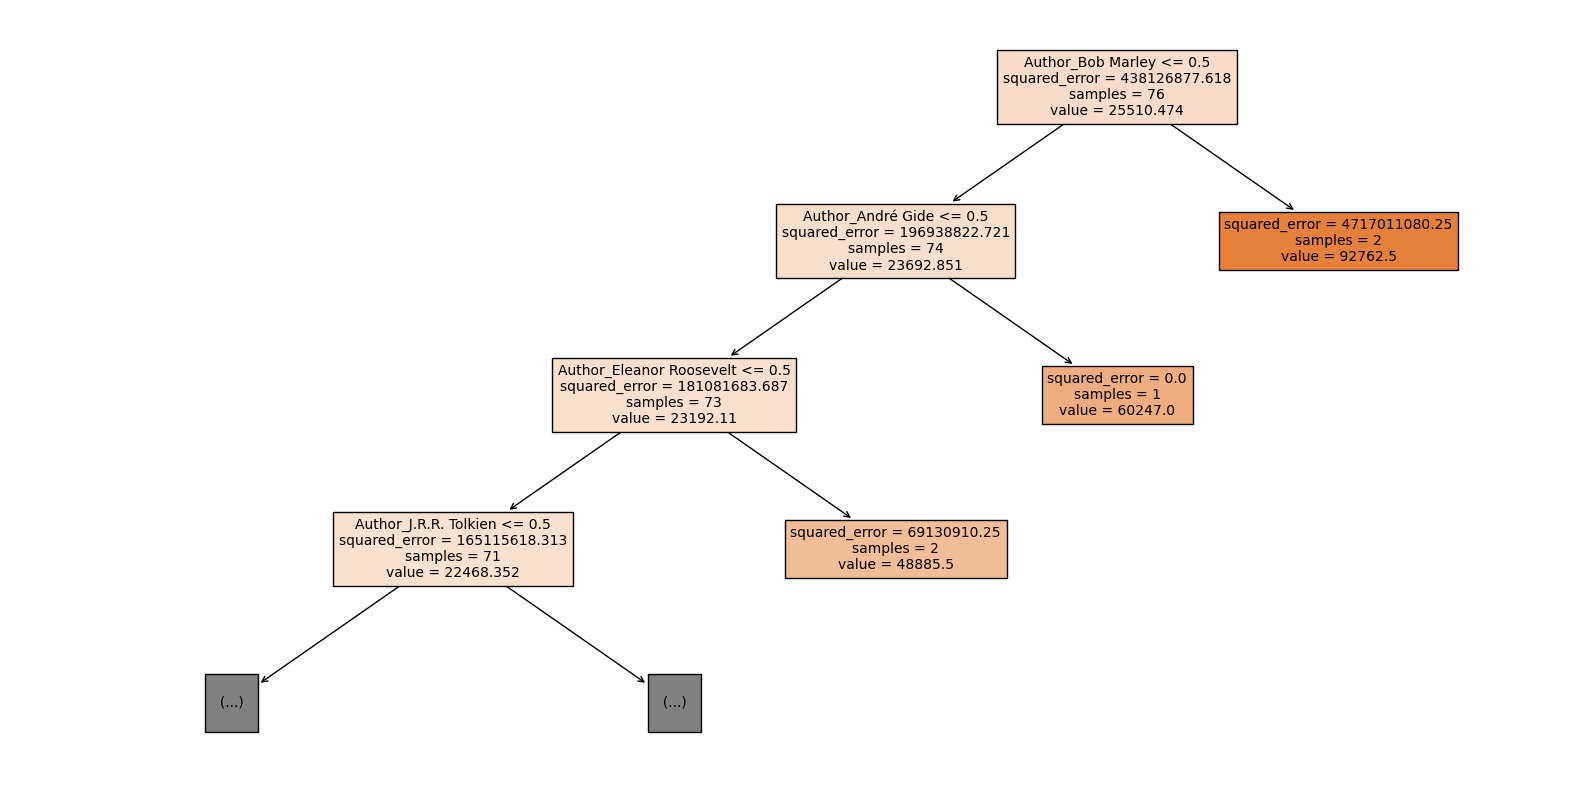

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Remove rows where 'Likes' is 0
data = data[data['Likes'] != 0]
# Leave the last one in the repeating row
data = data.drop_duplicates(subset=['Quote'], keep='last')

# Create a decision tree model 
tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model.fit(X_train_encoded, y_train)

# Predict for test
y_pred = tree_model.predict(X_test_encoded)

# Caculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

importances = tree_model.feature_importances_
feature_names = encoder.get_feature_names_out()

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot
feature_names_list = list(encoder.get_feature_names_out())
plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=feature_names_list, max_depth=3, fontsize=10)
plt.show()

###  2.3 Linear Regression

Mean Squared Error on Test set: 259635975.3662877


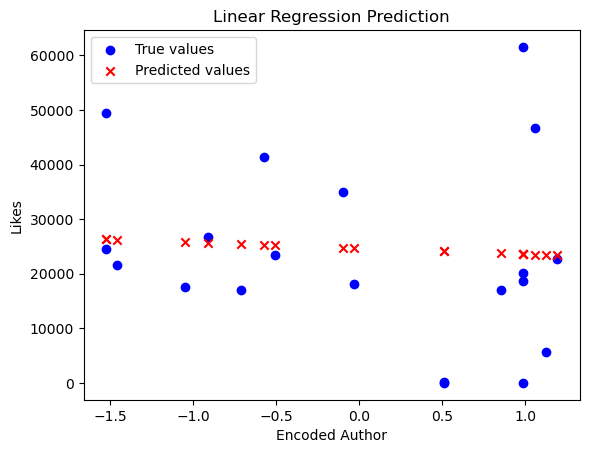

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler 

# Remove rows where 'Likes' is 0
data = data[data['Likes'] != 0]
# Leave the last one in the repeating row
data = data.drop_duplicates(subset=['Quote'], keep='last')

# Encode the "Author" column
encoder = LabelEncoder()
df['Author_encoded'] = encoder.fit_transform(df['Author'])

X = df[['Author_encoded']]
y = df['Likes']

# Standardlization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model using test sets
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test set: {mse}')

# Visulization
plt.scatter(X_test, y_test, color='blue', label='True values')
plt.scatter(X_test, y_pred, color='red', marker='x', label='Predicted values')
plt.xlabel('Encoded Author')
plt.ylabel('Likes')
plt.legend()
plt.title('Linear Regression Prediction')
plt.show()


**Analysis**

**1. MSE Analysis**

Random forest: MSE = 398291342.453111

Decision tree: MSE = 368244525.2983317

Linear regression: MSE = 221114671.44384342

The smaller the MSE (mean square error), the better the model performs. From the above results, we can see that linear regression has the smallest MSE and performs the best. The second is the decision tree, and the last is the random forest.

Feature importance analysis:

I only get feature importance from the decision tree. In the decision tree, feature importance gives the effect of each feature on the predicted output:

Bob Marley: 0.422887 - This means that Bob Marley's quote has the greatest importance for predicting popularity.
Eleanor Roosevelt and J.R.R. Tolkien: Have similar influence, around 0.1059 and 0.1056.
This shows a stronger correlation between certain authors and the popularity of quotes.

**Summary** : Linear regression models seem to perform best for this task.
According to the feature importance of the decision tree model, we can learn that the identity of some authors has a stronger correlation with the popularity of quotes.

**2. Visualization Analysis**

1. **RandomForestRegressor - Bar Chart**:
- The bar chart shows the importance of different authors as features when predicting target variables.
Bob Marley is the most important author, which probably means that his quotes are more popular than other authors.
This also supports the idea that there is a relationship between authorship and the popularity of quotes.

2. **Decision Tree visualization**:
- The figure shows a decision tree model.
- As can be seen from the decision tree, different authors have an effect on the number of likes of quotes. For example, for Eleanor Roosevelt's famous quotes, the average number of likes is 23,082, while for some other authors, the number is different.
- Further evidence that authorship may influence the popularity of quotes.

3. **Linear Regression Prediction Chart**:
- The graph shows the relationship between the true value and the predicted value.
The -x axis represents the "coded author" and the Y-axis represents the "likes".
- As you can see from the graph, some of the authors' quotes get a higher number of likes, while others get a lower number. However, there were differences between the predicted and true values, suggesting that the model may not have fully accurately captured the relationship between authors and likes.

**Summary** : From the above analysis, we can see that authorship may indeed affect the popularity of quotes. Different authors have different effects on the number of likes for quotes, which is reflected in both the decision tree and the feature importance graph. The linear regression plot shows the accuracy of the model in predicting this relationship. Overall, we can conclude that there is indeed a relationship between authorship and the popularity of quotes.

# Summary

In summary, it can be concluded from my analysis and model predictions that there is indeed some correlation between the identity of the author and the popularity of the introduction. Quotes from some authors may be more popular than others. This can be due to various reasons, such as the author's popularity, the content of the introduction, etc. However, the specific causes require further research and analysis.